In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from collections import defaultdict
import io
from tqdm.auto import tqdm

from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from torchvision.transforms import v2 as transforms_v2
from pytorch_msssim import ssim, ms_ssim

from Iwildcam_Pretrain import Autoencoder, Encoder, Decoder, IWildCamDataset
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

In [73]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "best_checkpoints_vanilla/"
HEIGHT = 96
WIDTH = 160
PRECISION = 32
DO_CACHING = False
# DATASET_ROOT = "/data/vision/beery/scratch/data/iwildcam_unzipped"
DATASET_ROOT = "/tmp/iwildcam_unzipped"

Device: cuda:0


In [74]:
def get_lora_model(
        latent_dim,
        lora_precision=None,
        loraize_encoder = False,  # no reason really to do this unless we want to reduce memory footprint
        loraize_decoder = True,
        finetune = True,
):
    if finetune and lora_precision == 32:
        lora_precision = None

    lora_config = {
        torch.nn.Conv2d: {
            'cls': LoRAConv2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.Linear: {
            'cls': LoRALinear,
            'config': {
                'rank': 4,
                'alpha': 2,
                'delta_bias':  False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.ConvTranspose2d: {
            'cls': LoRAConvTranspose2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        }
    }

    # load two copies so we can lora-ize one
    pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model for latent dim {latent_dim}, loading...")
        _model = Autoencoder.load_from_checkpoint(pretrained_filename)
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        raise Exception
    
    if not finetune:
        return model

    if loraize_encoder:
        for i, module in enumerate(_model.encoder.net.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path
            else:
                # freeze all other parameters
                for p in module.parameters():
                    p.requires_grad_(False)

    if loraize_decoder:
        for i, module in enumerate(_model.decoder.linear.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.decoder.net.children()): 
            if type(module) in lora_config.keys():
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path
            else:
                # freeze all other parameters
                for p in module.parameters():
                    p.requires_grad_(False)

    del _model # get rid of the clone
    return model

In [75]:
def compute_bits_per_pixel(model, latent_dim, lora_precision, width, height):
    param_size = 0
    for name, param in model.named_parameters():
        if "delta" in name:
            param_size += param.nelement() * (lora_precision / 8)

    # assume we don't have to transmit these if they are fixed -- this would be alpha, rank hyperparams
    buffer_size = 0

    latent_size = latent_dim * 4  # TODO: this is for full precision models, handle quantized models as well


    param_bpp = 8 * (param_size + buffer_size) / (width * height)
    latent_bpp = 8 * latent_size / (width * height)

    return param_bpp, latent_bpp

In [76]:
our_test_set_ids = [292, 181, 430, 20, 4]
latent_dim = 256

results = []

for lora_precision in [0, 4, 8, 32]:
    finetune = lora_precision is not None

    for loc_id in our_test_set_ids:
        test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
        if DO_CACHING:
            test_set.cache_on_device_(device)
            test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
        test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)

        model = get_lora_model(latent_dim, lora_precision, finetune=finetune)
        # print(model)
        
        # Freeze decoder if specified
        # TODO remove this once lora-ize decoder works
        # freeze_decoder = True
        # if freeze_decoder:
        # for param in model.decoder.parameters():
        #     param.requires_grad = False
        # print(f"Decoder frozen for location {loc_id}")

        trainer = pl.Trainer(
            default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
            accelerator="gpu" if str(device).startswith("cuda") else "cpu",
            precision=PRECISION,
            devices=1,
            max_epochs=1,
            callbacks=[
                ModelCheckpoint(save_weights_only=True),
                LearningRateMonitor("epoch")
            ]
        )

        # Train the model
        # Overfit to the test set
        if finetune:
            trainer.fit(model, test_loader, test_loader)
            save_path = os.path.join(CHECKPOINT_PATH, f"iwildcam_latent_dim={latent_dim}_lora_loc={loc_id}.ckpt")
            trainer.save_checkpoint(save_path)

        test_metrics = trainer.test(model=model, dataloaders=test_loader)[0]

        # test_reconstruction_error = test_results[0]['test_loss']
        # test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches? Timm: docs say default aggregation is torch.mean

        param_bpp, latent_bpp = compute_bits_per_pixel(model, latent_dim, lora_precision, WIDTH, HEIGHT)

        # Store results
        results.append(dict(
            finetuned=finetune,
            lora_precision=lora_precision,
            param_bpp=param_bpp,
            latent_bpp=latent_bpp,
            loc_id=loc_id,
            n_images=len(test_set.data['images']),
            **test_metrics,
        ))

        # release memory
        del test_set
        del model
        del trainer
        torch.cuda.empty_cache()

    # # Step 6: Visualize the results
    # # Bar chart of reconstruction error by location
    # locations, num_images, errors = zip(*results)

    # # Bar chart
    # plt.figure(figsize=(10, 6))
    # plt.bar(locations, errors, color='skyblue', edgecolor='black')
    # plt.xlabel("Location ID", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Reconstruction Error by Location", fontsize=14)
    # plt.grid(True)
    # plt.show()

    # # Scatter plot of number of images vs. reconstruction error
    # plt.figure(figsize=(10, 6))
    # plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
    # plt.xlabel("Number of Images", fontsize=12)
    # plt.ylabel("Reconstruction Error", fontsize=12)
    # plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
    # plt.grid(True)
    # plt.show()

Found pretrained model for latent dim 256, loading...


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/vision/beery/scratch/timm/micromamba/envs/aeco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total p

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.30it/s, v_num=28]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:10<00:00,  0.30it/s, v_num=28]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 40.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012073636054992676
        test_ssim           0.33719751238822937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.35it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.33it/s, v_num=22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.48it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03794088214635849
        test_ssim           0.2884368896484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s, v_num=21]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, v_num=21]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  6.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.007402451708912849
        test_ssim           0.46270373463630676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s, v_num=14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00, 10.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01035437174141407
        test_ssim           0.3289777636528015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=14]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.019494596868753433
        test_ssim           0.3644280731678009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.32it/s, v_num=29]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.31it/s, v_num=29]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 40.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012073814868927002
        test_ssim           0.33719316124916077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, v_num=23]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=23]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03794093430042267
        test_ssim           0.2884352207183838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, v_num=22]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s, v_num=22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.007402478717267513
        test_ssim           0.4627057909965515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 51.70it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Testing: |          | 0/? [16:29<?, ?it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child proce

Training: |          | 0/? [00:00<?, ?it/s]

^

Epoch 0:   0%|          | 0/17 [00:00<?, ?it/s] 

^^^^^^^^^^^^^^^^^^^^^
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
 ^^ ^^ ^ ^^ ^^  
^AssertionError ^ : ^ ^can only test a child process ^
^

Epoch 0: 100%|██████████| 20/20 [14:20<00:00,  0.02it/s, v_num=15]

^^^

^^

^^

^^

^^^^^^^^^^^
AssertionError^: ^^^^^^^^^^^can only test a child process^
^

Testing: |          | 0/? [16:31<?, ?it/s]

^

^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
AssertionError    : self._shutdown_workers()can only test a child process



Testing: |          | 0/? [16:31<?, ?it/s]

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>

    
if w.is_alive():Traceback (most recent call last):

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers() 
   File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
     if w.is_alive():  
^ ^  ^^^^^^^^^Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^ 

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
         assert self._parent_pid == os.getpid(), 'can only test a child process'^self._shutdown_workers()^
           ^^
  File "/data

Epoch 0: 100%|██████████| 20/20 [14:21<00:00,  0.02it/s, v_num=15]

^

^

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>

^^
^Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()
^^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    if w.is_alive():Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
^^
 Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^ ^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompressio

Epoch 0: 100%|██████████| 20/20 [14:22<00:00,  0.02it/s, v_num=15]

^

^^^

^^^^^
AssertionError: can only test a child process
^^

^

^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>

 Exception ignored in: Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

     Traceback (most recent call last):
 self._shutdown_workers()  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
           self._shutdown

  ^

^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 0: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:12<00:00,  1.36it/s, v_num=15]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00,  9.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010354530066251755
        test_ssim           0.32897457480430603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Testing: |          | 0/? [16:58<?, ?it/s],  0.49it/s, v_num=15]           
Epoch 0: 100%|██████████| 20/20 [14:47<00:00,  0.02it/s, v_num=15]
                                                  

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^^Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^^    ^self._shutdown_workers()^

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/data/v

Testing: |          | 0/? [16:58<?, ?it/s]

^

^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^
    AssertionErrorif w.is_alive():: 
can only test a child process
  

Testing: |          | 0/? [16:58<?, ?it/s]

    ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^Traceback (most recent call last):
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^^    ^self._shutdown_workers()

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
         assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

              ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^ ^

 ^ ^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^

Epoch 0: 100%|██████████| 20/20 [14:47<00:00,  0.02it/s, v_num=15]

^

^^

^^

^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
: AssertionError    can only test a child process  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers


if w.is_alive():^
self._shutdown_workers()^
    ^^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__


Epoch 0: 100%|██████████| 20/20 [14:47<00:00,  0.02it/s, v_num=15]

 ^Traceback (most recent call last):
^

   ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^^
Traceback (most recent call last):
^^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^^self._shutdown_workers()
^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

              ^ ^ ^ ^ ^^^^^^^^^^^^^^^^
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 

^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>^
^^^^^^Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    ^^^^^^self._shutdown_workers()^

  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
AssertionError:     if w.is_alive():can only test a child process

    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
   File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      ^self._shutdown_workers()^^^^^^^^^^^
  File "/data/vision/beery/scratch/

^^

Validation: |          | 0/? [00:00<?, ?it/s]

^^

^^^^^^^^^^^^
^  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ 
 AssertionError :  can only test a child process 
 

^

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Testing: |          | 0/? [16:59<?, ?it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 0: 100%|██████████| 20/20 [14:49<00:00,  0.02it/s, v_num=15]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa54d3ba200>
Traceback (most recent call last):
  File "/data/vision/beery/scratch/timm/micromamba/envs/aecom

Epoch 0: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=15]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.019494598731398582
        test_ssim           0.3644278943538666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.32it/s, v_num=30]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:09<00:00,  0.31it/s, v_num=30]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 26.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012073532678186893
        test_ssim           0.33720171451568604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=24]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=24]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.49it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.037940915673971176
        test_ssim           0.2884354293346405
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:21<00:00,  0.94it/s, v_num=23]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:21<00:00,  0.93it/s, v_num=23]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.007402081973850727
        test_ssim           0.4627007842063904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s, v_num=16]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s, v_num=16]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010354741476476192
        test_ssim           0.32898223400115967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=16]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=16]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01949458196759224
        test_ssim           0.36442822217941284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3/3 [00:10<00:00,  0.30it/s, v_num=31]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:10<00:00,  0.29it/s, v_num=31]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 15.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010220014490187168
        test_ssim           0.31049516797065735
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=25]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=25]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05212468281388283
        test_ssim           0.18352028727531433
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 20/20 [00:21<00:00,  0.92it/s, v_num=24]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 20/20 [00:21<00:00,  0.91it/s, v_num=24]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.00579620897769928
        test_ssim           0.4947199523448944
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s, v_num=17]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 17/17 [00:12<00:00,  1.31it/s, v_num=17]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 17/17 [00:01<00:00,  9.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.010401470586657524
        test_ssim           0.3272237479686737
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Found pretrained model for latent dim 256, loading...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.1 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.1 M     Trainable params
4.1 M     Non-trainable params
8.2 M     Total params
32.700    Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=17]           

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=17]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.022484179586172104
        test_ssim           0.3090202510356903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [77]:
jpeg_bpp = []
jpeg_ssim = []
for batch in tqdm(test_loader):
    for el in batch:
        pil_img = Image.fromarray((el.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

        img_byte_arr = io.BytesIO()
        pil_img.save(img_byte_arr, format='JPEG')

        jpeg_bpp.append((len(img_byte_arr.getvalue()) * 8) / (el.shape[1] * el.shape[1]))

        pil_img = Image.open(img_byte_arr, mode='r')

        el_reconstructed = transforms_v2.ToTensor()(transforms_v2.ToDtype(torch.float32, scale=True)(pil_img))

        jpeg_ssim.append(ssim(el[None, ...], el_reconstructed[None, ...], 1))

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


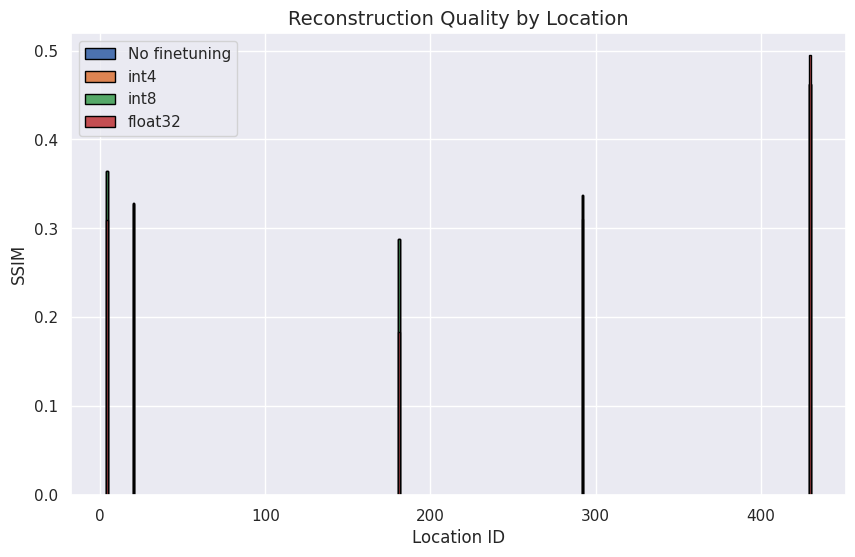

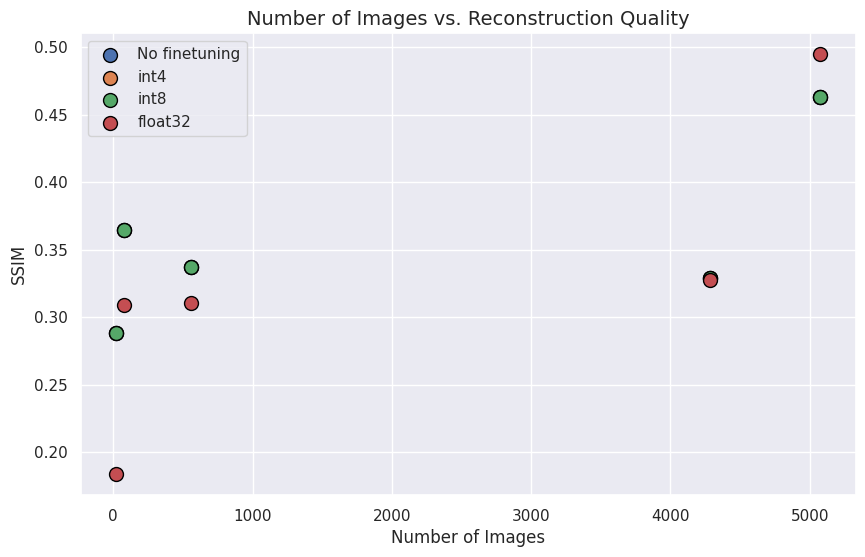

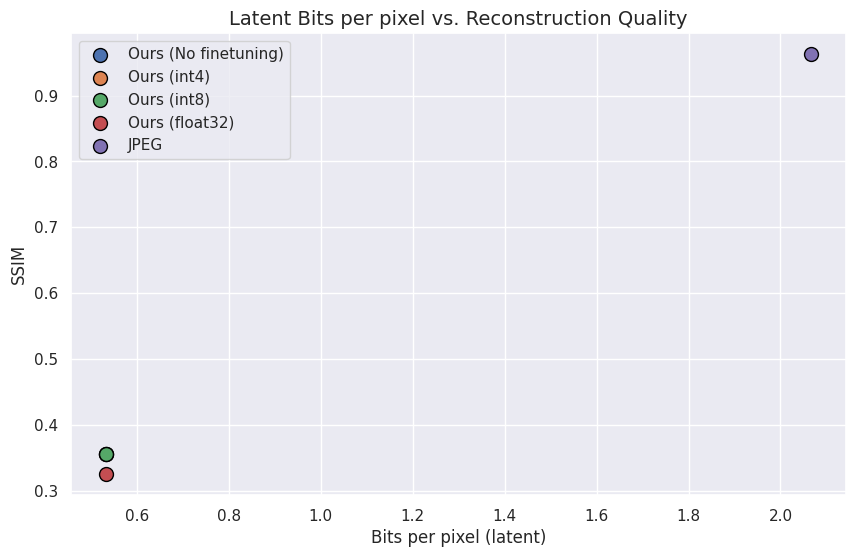

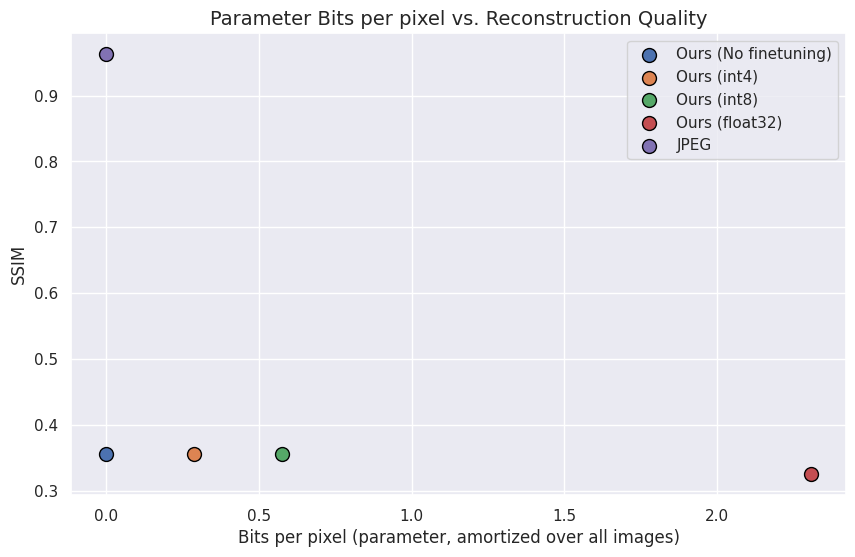

In [78]:
# Step 6: Visualize the results
# Bar chart of reconstruction error by location

lora_precision_labels = dict({ 32: "float32", 8: "int8", 4: "int4", 0: "No finetuning" })

results_df = pd.DataFrame(results)
results_df["lora_precision"] = results_df["lora_precision"].fillna(-1)
    

# Bar chart
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.bar(results_df[results_df["lora_precision"] == lora_precision]["loc_id"], results_df[results_df["lora_precision"] == lora_precision]["test_ssim"], edgecolor='black', label=lora_precision_labels[lora_precision])
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.title("Reconstruction Quality by Location", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["n_images"], results_df[results_df["lora_precision"] == lora_precision]["test_ssim"], edgecolor='black', s=100, label=lora_precision_labels[lora_precision])
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.title("Number of Images vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Latent Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter(results_df[results_df["lora_precision"] == lora_precision]["latent_bpp"].mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.scatter(np.mean(jpeg_bpp), np.mean(jpeg_ssim), edgecolor='black', s=100, label="JPEG")
plt.xlabel("Bits per pixel (latent)", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.title("Latent Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Param Bits per pixel
plt.figure(figsize=(10, 6))
for lora_precision in results_df["lora_precision"].unique():
    plt.scatter((results_df[results_df["lora_precision"] == lora_precision]["param_bpp"] / results_df[results_df["lora_precision"] == lora_precision]["n_images"]).mean(), results_df[results_df["lora_precision"] == lora_precision]["test_ssim"].mean(), edgecolor='black', s=100, label=f"Ours ({lora_precision_labels[lora_precision]})")
plt.scatter(0, np.mean(jpeg_ssim), edgecolor='black', s=100, label="JPEG")
plt.xlabel("Bits per pixel (parameter, amortized over all images)", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.title("Parameter Bits per pixel vs. Reconstruction Quality", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()